In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive')

In [ ]:
import matplotlib
import pandas as pd
from pathlib import Path
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt, image as img
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    MaxPool2D,
    ReLU,
    Flatten,
    Dense,
    UpSampling2D,
)
from skimage.transform import resize
from tensorflow import Tensor
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Input
from tensorflow import Tensor
from scipy.stats import mannwhitneyu
from tabulate import tabulate

import progressbar

# random seed generator
np.random.seed(3)
tf.random.set_seed(7)

In [ ]:
data_dir = Path('Learn_AI_project')

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

14486


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode='grayscale',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 14486 files belonging to 2 classes.
Using 11589 files for training.


In [ ]:
val_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode='grayscale',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 14486 files belonging to 2 classes.
Using 2897 files for validation.


In [ ]:
class_names = train_data.class_names
print(class_names)

['1NonCOVID', '2COVID']


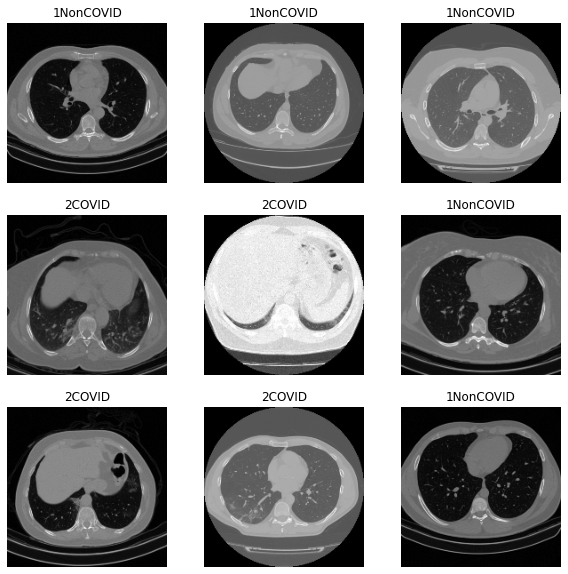

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze().astype(int), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.95143825


In [ ]:
print(first_image)

tf.Tensor(
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]], shape=(180, 180, 1), dtype=float32)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 1

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

In [ ]:
earlystopping_callback = EarlyStopping(monitor='val_loss', patience=3)
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
    
learningrate_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=20,
  callbacks=[earlystopping_callback, learningrate_callback]
)

Epoch 1/20
363/363 [==============================] - 55s 140ms/step - loss: 0.3551 - accuracy: 0.8548 - val_loss: 0.2466 - val_accuracy: 0.9078 - lr: 0.0010
Epoch 2/20
363/363 [==============================] - 9s 24ms/step - loss: 0.2162 - accuracy: 0.9166 - val_loss: 0.1694 - val_accuracy: 0.9379 - lr: 0.0010
Epoch 3/20
363/363 [==============================] - 9s 25ms/step - loss: 0.1458 - accuracy: 0.9439 - val_loss: 0.1168 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 4/20
363/363 [==============================] - 9s 26ms/step - loss: 0.1033 - accuracy: 0.9607 - val_loss: 0.0982 - val_accuracy: 0.9662 - lr: 0.0010
Epoch 5/20
363/363 [==============================] - 10s 27ms/step - loss: 0.0727 - accuracy: 0.9730 - val_loss: 0.1554 - val_accuracy: 0.9348 - lr: 0.0010
Epoch 6/20
363/363 [==============================] - 9s 24ms/step - loss: 0.0543 - accuracy: 0.9786 - val_loss: 0.1092 - val_accuracy: 0.9575 - lr: 9.0484e-04
Epoch 7/20
363/363 [==============================] - 9s 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


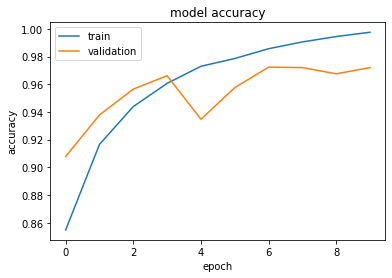

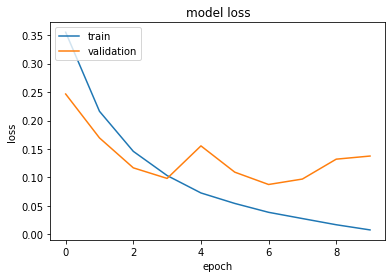

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred = model.predict(val_data)
y_pred = y_pred>0.5
y_pred = np.squeeze(y_pred, axis=1)
y_pred.astype(int)
# y_pred
len(y_pred)

2897

In [ ]:
type(val_data)
i = 0
y_true = np.concatenate([y for x, y in val_data], axis=0)
# for images, labels in val_data.take(-1):
#   i += 1
#   numpy_labels = labels.numpy()
#   print(numpy_labels)
  # print(len(numpy_labels))
print(y_true)
print(len(y_true))

[0 1 0 ... 1 1 1]
2897


In [ ]:
from sklearn import metrics

In [ ]:
report = metrics.classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1375
           1       0.99      0.95      0.97      1522

    accuracy                           0.97      2897
   macro avg       0.97      0.97      0.97      2897
weighted avg       0.97      0.97      0.97      2897



In [ ]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[1365   10]
 [  71 1451]]
